In [18]:
%reset -f
# This toggle button code is borrowed from [StackOverflow/ErickShepherd](https://stackoverflow.com/a/53136940)

import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):
    
    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """
    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))

def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """
    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]

state = False
toggle_code(state)

CodeToggleButton = widgets.ToggleButton(state, description = button_descriptions[state])
CodeToggleButton.observe(button_action, "value")


#### Please run all the cells before you proceed. If you want to see the code, there is a show/hide code toggle at the end.



***

# *NOTEBOOK AIM : Explore the performance of market ETFs and their leveraged counterparts.* 

***

## *Before we start, let me introduce two ETFs that we would be using throughout this notebook.*

## *SPY : ETF that tracks the prices of top 500 US companies.*
## *SPXL : Leveraged ETF that returns 3 times that of SPY every day (positive or negative).*

## *For more information on leveraged ETFs, please refer to [Investopedia](https://www.investopedia.com/terms/l/leveraged-etf.asp).*

In [19]:
%%capture

# Install required libraries on kernel 
#!pip install numpy
#!pip install matplotlib
#!pip install pandas-dataread
#!pip install pandas-datareader
#!pip install yfinance
#!pip install ipywidgets
!pip install backtrader
!pip install matplotlib==3.2.0



In [20]:
#%reset -f
# importing all necessary libraries
import numpy as np; import matplotlib ; import matplotlib.pyplot as plt; import pandas as pd;
import pandas_datareader.data as pd_datareader; 
import datetime; 
import backtrader as bt; 
import yfinance as yf
import ipywidgets as widgets
from IPython.display import display, HTML, Markdown, clear_output
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
#from IPython.core.display import display, HTML

#matplotlib.use('QT5Agg')
%matplotlib inline
#%matplotlib notebook

plt.rcParams["figure.figsize"] = (15, 10) # (w, h)
#plt.style.use('dark_background')


In [21]:
# setting start and end time of investment
start_time_chosen = datetime.datetime(2020, 2, 14)
end_time_chosen = datetime.datetime(2021, 1, 1)
# setting initial investment value 
inv_initial = 1
#Adjusted times to account for valid 300ma
start_time = start_time_chosen - datetime.timedelta(300)
end_time = end_time_chosen #- datetime.timedelta(300)

In [22]:
# Function returns drawdown of a stock or portfolio
def stock_drawdown(stock_price):
    stock_returns_val = stock_price/stock_price[0] # _val added to avoid conflict with function
    return round(-(stock_returns_val.cummax()-stock_returns_val).div(stock_returns_val.cummax())*100,2)

# Function returns time required to break even in future if invested on that particular day
def stock_timetillprofit(stock_price):
    stock_price_trimmed = stock_price.iloc[0:stock_price.argmax()] #trimming data to highest value
    len_data = len(stock_price_trimmed) # size of resulting data
    days_timetillprofit = stock_price_trimmed*0
    #print(len(days_timetillprofit))
    for i in range(len_data-1) :
        timetillprofit_dummy1 = (stock_price_trimmed > stock_price_trimmed.iloc[i]).astype(int)
        timetillprofit_dummy2 = (timetillprofit_dummy1.iloc[i+1:len_data].idxmax() - 
                                 timetillprofit_dummy1.index[i]).days
        days_timetillprofit.iloc[i] = timetillprofit_dummy2
    return days_timetillprofit

# Function returns leveraged returns of a stock accounting for expense ratio
def stock_leveraged_returns(stock_price, leverage, expense_ratio = 0.0093, inv_initial=1):
    # Assuming number of trading days as 252 in an year
    stock_lev_returns = (1 + (stock_price.pct_change(1) - expense_ratio/252)*leverage ).cumprod()
    stock_lev_returns[0] = 1
    return stock_lev_returns*inv_initial

## *Investing in SPXL (3 times leveraged version of SPY) in April 2020, we would have made in Nov 2021 roughly 3 times of what SPY would have given us* : 
### 



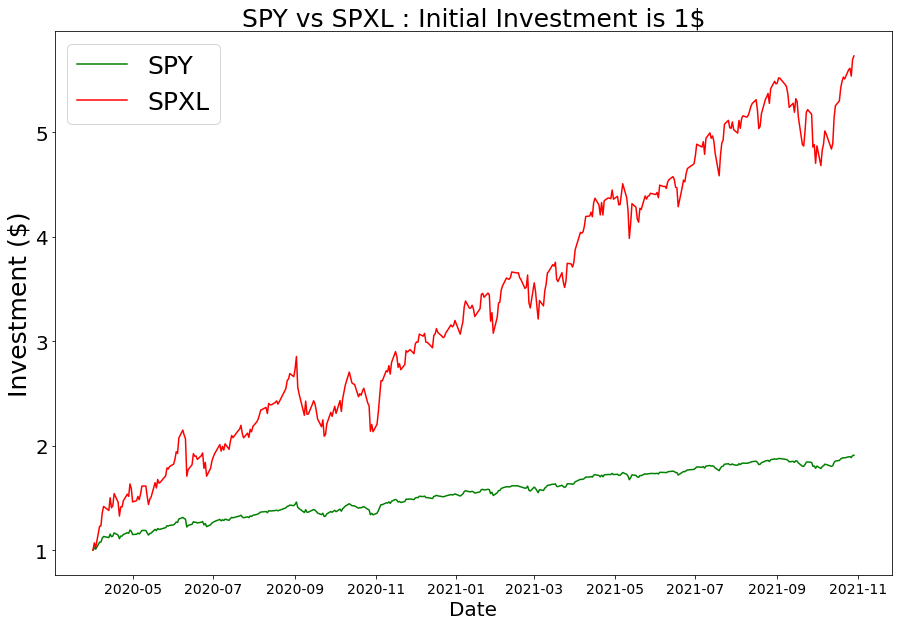

In [23]:
display(Markdown('''## *Investing in SPXL (3 times leveraged version of SPY) in April 2020, we would have made in Nov 2021 roughly 3 times of what SPY would have given us* : 
### \n
'''))

start_time = datetime.datetime(2020,4,1) # investment initiated time
end_time = datetime.datetime(2021,11,1) # investment withdrawing time

# Choosing the stocks
SPY = yf.download('SPY',start_time, end_time, progress=False)['Adj Close'].rename('SPY')
SPXL = yf.download('SPXL', start_time, end_time, progress=False)['Adj Close'].rename('SPXL')
SPXL = stock_leveraged_returns(SPY, 3, 0.0093, inv_initial)

# Plotting returns
plt.plot(SPY/SPY[0], color = 'g', label = 'SPY')
plt.plot(SPXL/SPXL[0], color = 'r', label = 'SPXL')
plt.legend(prop={'size': 25}); plt.title('SPY vs SPXL : Initial Investment is {}$'.format(inv_initial), fontsize = 25) ; 
plt.xticks(fontsize=14);plt.yticks(fontsize=20);
ax = plt.gca()
ax.set_xlabel('Date', fontsize=20); ax.set_ylabel('Investment ($)', fontsize=25); 


## *But SPXL doesn't always outperform SPY. Lets change our investment start year from 2020 April to 2000 April*
### 



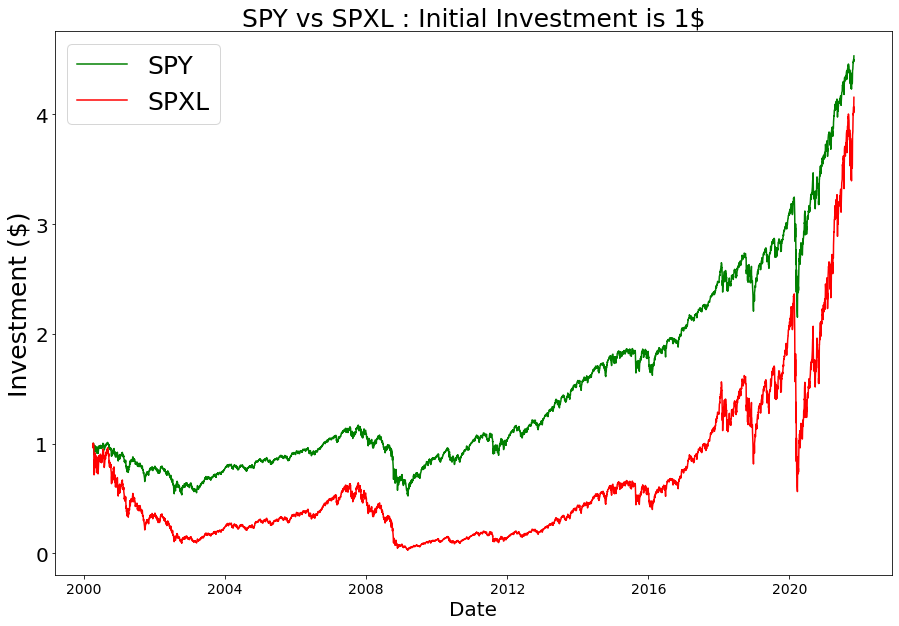

In [24]:
display(Markdown('''
## *But SPXL doesn't always outperform SPY. Lets change our investment start year from 2020 April to 2000 April*
### \n
'''))

start_time = datetime.datetime(2000,4,1) # investment initiated time
end_time = datetime.datetime(2021,11,1) # investment withdrawing time

# Choosing the stocks
SPY = yf.download('SPY',start_time, end_time, progress=False)['Adj Close'].rename('SPY')
SPXL = yf.download('SPXL', start_time, end_time, progress=False)['Adj Close'].rename('SPXL')
SPXL = stock_leveraged_returns(SPY, 3, 0.0093, inv_initial)

# Plotting returns
plt.plot(SPY/SPY[0], color = 'g', label = 'SPY')
plt.plot(SPXL/SPXL[0], color = 'r', label = 'SPXL')
plt.legend(prop={'size': 25}); plt.title('SPY vs SPXL : Initial Investment is {}$'.format(inv_initial), fontsize = 25) ; 
plt.xticks(fontsize=14);plt.yticks(fontsize=20);
ax = plt.gca()
ax.set_xlabel('Date', fontsize=20); ax.set_ylabel('Investment ($)', fontsize=25); 


## *Now SPY outperforms SPXL !* 

## *What happened ? SPXL is supposed to return three times of what SPY returns, Isn't it ? It does, but only for one day.*

## *What does it mean?*

## *Lets say SPY is at 1\\$ on Day 1 and it falls 10\%. So, it is 0.9\$ at the end of the day. On Day 2, SPY rises 10%. So, it is raises to 0.99\\$. Notice that even though SPY increased 10% again after it fell 10%, it did not come to original price. This is what we call volatility drag.* 

## *Now, Lets see the case of SPXL. When SPY falls 10% on Day 1, SPXL should fall 30%. So, it's value at the end of Day 1 is 0.7\\$. Next Day, when SPY raises back 10%, SPXL raises 30% which brings 0.7\\$ to 0.91\\$. This is below SPY price of 0.99\\$ that day. So, volatility drag is much higher for SPXL.* 

## *Ok, Volatility drag is bad and leveraged ETFs have a lot of it. So, How bad can it get?*

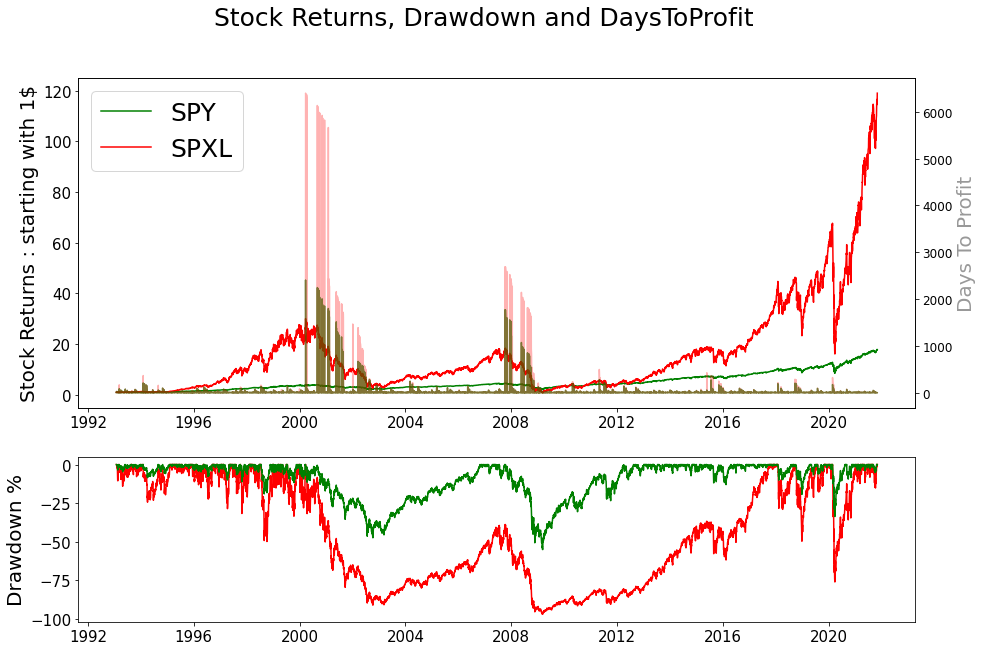

In [25]:
start_time = datetime.datetime(1993,1,1) # investment initiated time
end_time = datetime.datetime(2021,11,1) # investment withdrawing time
SPY = yf.download('SPY',start_time, end_time, progress=False)['Adj Close'].rename('SPY')
SPXL = yf.download('SPXL', start_time, end_time, progress=False)['Adj Close'].rename('SPXL')
SPXL = stock_leveraged_returns(SPY, 3, 0.0093, inv_initial)
df_perf = pd.DataFrame({'Stock':['SPY','SPXL'] })
SPY_drawdown = stock_drawdown(SPY); SPXL_drawdown = stock_drawdown(SPXL)
df_perf['Max_Drawdown'] = [str(SPY_drawdown.min())+'%('+str(SPY_drawdown.idxmin().date())+')',
                           str(SPXL_drawdown.min())+'%('+str(SPXL_drawdown.idxmin().date())+')']
# plotting time to break even
fig, (axs1,axs2) = plt.subplots(2,1,gridspec_kw={'height_ratios':[2,1]})
axs1.plot(SPY/SPY[0],'-g', label='SPY')
axs1.plot(SPXL/SPXL[0], '-r', label='SPXL')
axs1.legend(prop={'size': 25});
axs1.tick_params(axis='y',labelcolor='black', labelsize=15); axs1.set_ylabel('Stock Returns : starting with {}$'.format(inv_initial), fontsize=20)
axs1.tick_params(axis='x',labelcolor='black', labelsize=15); 
ax11 = axs1.twinx()
ax11.plot(stock_timetillprofit(SPY), color='green', alpha=0.7)
ax11.plot(stock_timetillprofit(SPXL), color = 'red', alpha=0.3); #ax11.set_yscale('log')
ax11.tick_params(axis='y', labelcolor = 'black', labelsize=12); ax11.set_ylabel('Days To Profit', fontsize=20, color='black',alpha=0.4)
fig.suptitle('Stock Returns, Drawdown and DaysToProfit', fontsize=25)

axs2.plot(SPXL_drawdown.index, SPXL_drawdown, label = 'SPY', color='red', alpha = 1)                                                     
axs2.plot(SPY_drawdown.index, SPY_drawdown, label = 'SPXL', color='green', alpha = 1)  
axs2.set_ylabel('Drawdown %', fontsize=20)
axs2.tick_params(axis='y', labelcolor = 'black', labelsize=15);
axs2.tick_params(axis='x', labelcolor = 'black', labelsize=15);


## *We can clearly see three major crashes in 2000 (Tech Bubble), 2008 (Financial Crisis) and 2020 (Covid). All those three times, SPXL was dragged down to obscenely low levels. How low?* 

## *Look at the drawdown which represents the drop from previous peak. SPY was never below -60% but SPXL was dragged down -90% twice and it just escaped that fate in 2020. In fact, Lot of leveraged oil ETFs went bankrupt in 2020 because they dropped more than 99% !*

## *You can also notice the number of days it takes to profit if you had invested on that particular day. For example, if you had invested in SPY in 2000, it would have taken 2000 days or 6 years to make any profit. If you had invested in SPXL? it would have taken 6000 days or more than 15 years to just breakeven!* 

## *To summarize, Leveraged ETFs are great investments when the market is going up but when the market is going down? they are the worst choice that can keep you under water for years or even lead to bankruptcy.*

## *Now you might be thinking, what if I invest in Leveraged ETFs when the market is going up and get out when the market starts going down?*

## *That's a good idea but there is one problem. How do we know if the market is going up or down? Market might go up 5% one day and fall 10% next day. So, to have a quantitative reference of market going up or down, Let's use the idea of moving averages.* 

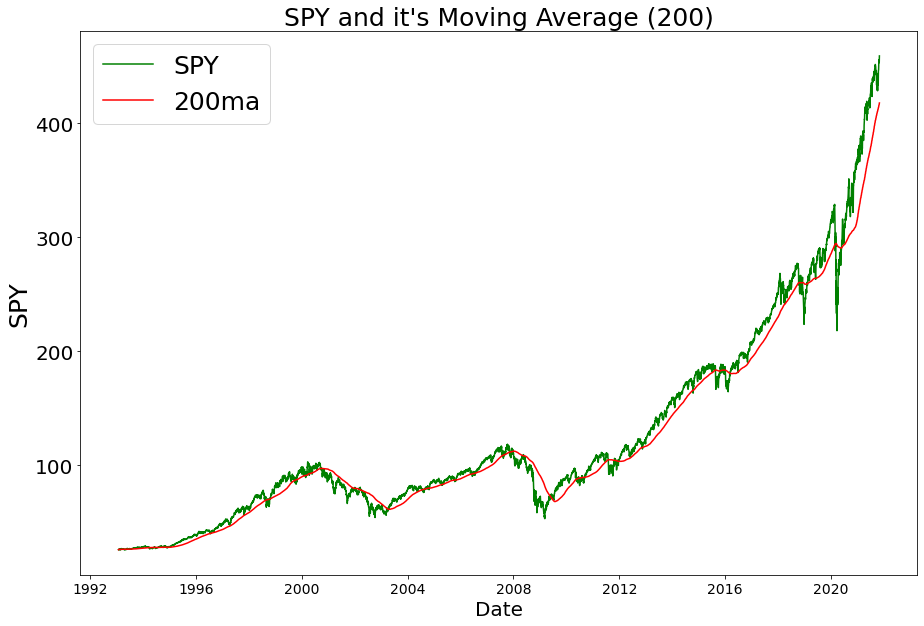

In [26]:

SPY_200ma = pd.Series(pd.Series(SPY).rolling(window=200,min_periods=1).mean().values)
SPY_200ma.index = SPY.index

plt.plot(SPY, color = 'g', label = 'SPY')
plt.plot(pd.Series(SPY_200ma), color = 'r', label = '200ma')
plt.legend(prop={'size': 25}); plt.title('SPY and it\'s Moving Average (200)', fontsize = 25) ; 
plt.xticks(fontsize=14);plt.yticks(fontsize=20);
ax = plt.gca()
ax.set_xlabel('Date', fontsize=20); ax.set_ylabel('SPY', fontsize=25); 

## *Moving Average is the mean of last n number of values. For 200ma, n is 200. 200ma is considered as a very important technical level by traders. There are various elaborate ways to calculate this mean, Let's use simple arithmetic mean for now for 200ma.*

## *Now that we know how to decide if the market is going up or down and what to do when that happens, we need a platform to backtest our strategy and compare the performance to just buying and holding the ETF. For this, we use backtrader library.* 

In [27]:
class SingleMACross(bt.Strategy): 
    params = (
        ('safetymargin', 0.02),
        ('MA_num', 300),
    )
    def __init__(self):      
        MA_ref = bt.ind.SMA(self.datas[1], period=self.params.MA_num)
        self.ma300_ref = bt.ind.SMA(self.datas[1], period=300, plot=False)
        self.AboveMA = self.datas[1] > (1+self.params.safetymargin)*MA_ref
        self.BelowMA = MA_ref > (1+self.params.safetymargin)*self.datas[1]        
    def next(self):
        if not self.position and self.ma300_ref > 0 and self.AboveMA > 0:
            self.buy(self.datas[0])
        if self.position and self.ma300_ref > 0 and self.BelowMA > 0:
            self.sell()

class BuyAndHold(bt.Strategy):    
    def __init__(self):
        self.ma300_ref = bt.ind.SMA(self.datas[0], period=200, plot=False)
    def next(self):
        if not self.position and self.ma300_ref > 0 :
            self.buy(self.datas[0]) 
            
def StrategyPerformance(datas,strategy,inv_initial,start_time,end_time,plot=False,**kwargs):
    
    cerebro_engine = bt.Cerebro()
    for i in datas :
        cerebro_engine.adddata(i)
    cerebro_engine.broker.setcash(inv_initial)
    cerebro_engine.addsizer(bt.sizers.AllInSizer, percents = 100)
    cerebro_engine.addanalyzer(bt.analyzers.Returns)
    cerebro_engine.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate = 0)
    cerebro_engine.addanalyzer(bt.analyzers.VWR)
    cerebro_engine.addanalyzer(bt.analyzers.DrawDown)
    cerebro_engine.addstrategy(strategy,**kwargs)
    #cerebro_engine.addobserver(bt.observers.Broker)
    #cerebro_engine.addobserver(bt.observers.BuySell)

    cerebro_output = cerebro_engine.run()

    if plot == True:
        cerebro_engine.plot(iplot=False, fmt_x_ticks = '%Y-%b-%d') #,start=start_time_chosen, end=end_time_chosen)
    strategy_perf = [ 
                      (cerebro_engine.broker.getvalue()+cerebro_engine.broker.getcash()), 
                      cerebro_output[0].analyzers.returns.get_analysis()['rnorm100'],
                      cerebro_output[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
                      cerebro_output[0].analyzers.sharperatio.get_analysis()['sharperatio'],
                      cerebro_output[0].analyzers.vwr.get_analysis()['vwr']
                    ]
    FinalPortfolioValue = strategy_perf[0]
    TotalReturns = round((FinalPortfolioValue-inv_initial)/inv_initial,2) 
    TotalTimeYears = (end_time - datetime.timedelta(300) - start_time).days/365
    CAGR = round(((FinalPortfolioValue/inv_initial)**(1/TotalTimeYears) - 1)*100,2)
    MaxDrawdown =  round(strategy_perf[2],2)
    Sharpe = round(strategy_perf[3],2)
    VWR = round(strategy_perf[4],2)
    
    return TotalReturns, CAGR, Sharpe, VWR, MaxDrawdown    

def TickerDataBt (ticker, lev, start_time, end_time, stock_leveraged_returns) :

    Stock_data0 = yf.download(ticker,start_time, end_time, progress=False)['Adj Close'].rename(ticker)
    Stock_data = stock_leveraged_returns(Stock_data0,lev, expense_ratio=lev*0.003)

    # Converting series to dataframes and normalizing starting value to 1
    # [300] is used here because data is started 300 days earlier than actual trading starting day to have valid 300ma values
    Stock_data_df = Stock_data.to_frame("close") ; Stock_data_df = Stock_data_df/Stock_data_df["close"][300];

    #Adding ohlc columns and  make it compatible with backtrader
    for i in ["open", "high", "low"]:
        Stock_data_df[i] = Stock_data_df["close"]

    Stock_data_df["volume"] = 0 

    Stock_data_bt = bt.feeds.PandasData(dataname=Stock_data_df)

    return Stock_data_bt   


In [28]:
ticker_ref = 'SPY'; leverage_ref = 1.0; ticker_trade = 'SPY'; leverage_trade = 3.0

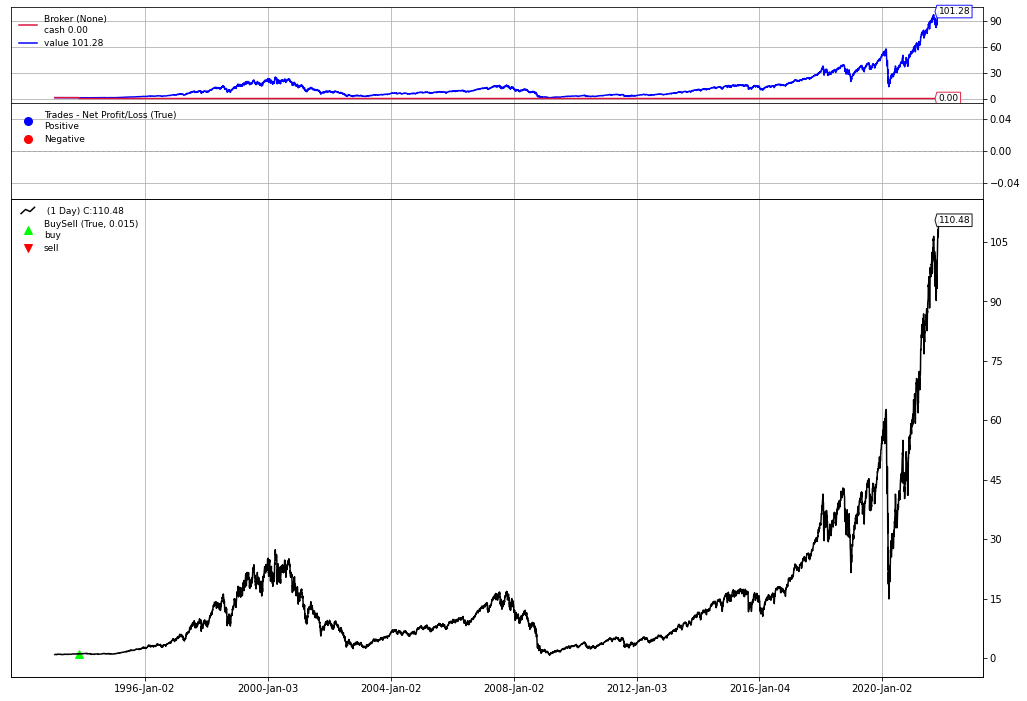

#### Portfolio Returns(Buy And Hold) : 

Total Returns (for every 1$ invested) : 100.28$
CAGR: 17.91%
Max Drawdown: -97.14%
Sharpe Ratio: 0.6
VWR: 5.93


In [29]:
Stock_ref_bt =  TickerDataBt (ticker_ref, leverage_ref, start_time, end_time, stock_leveraged_returns)
Stock_trade_bt =  TickerDataBt (ticker_trade, leverage_trade, start_time, end_time, stock_leveraged_returns)

TotalReturns_BH, CAGR_BH, Sharpe_BH, VWR_BH, MaxDrawdown_BH = \
    StrategyPerformance([Stock_trade_bt],BuyAndHold,inv_initial,start_time,end_time,plot=True)

display(Markdown('#### Portfolio Returns(Buy And Hold) : '))
print(f"Total Returns (for every 1$ invested) : {TotalReturns_BH}$\nCAGR: {CAGR_BH}%")
print(f"Max Drawdown: -{MaxDrawdown_BH}%\nSharpe Ratio: {Sharpe_BH}\nVWR: {VWR_BH}")

## *Image above shows the results of BuyAndHold Strategy i.e., we buy SPXL at the beginning and never sell it. All the graphs start from 1$.*

## *Colored lines in the first row show cash(red) and portfolio value (blue). Second row(DataTrades) can ignored as it is relevant to your current discussion. Black line in the third row represents the ETF we chose for buying/selling. Green arrow at the beginning represents the buying point. You can see that cash becomes zero and portfolio value starts changing exactly at the point of green arrow as expected.*

## *Chart starts 300 days before our initial time chosen to have valid 300ma. Even though BuyAndHold should show same value for portfolio as ETF chosen, they are different here. Because expense fees were approximated as 0.3% $\times$ leverage_number for simplicity sake, which in reality varies for each ETF.* 

## *Also displayed are the performance metrics. Total returns is your net profit/loss. CAGR is compounded annula growth rate for the time period we chose. Max-drawdown is the maximum drawdown of the portfolio from it's previous peak. Sharpe ratio is a classic parameter used by trading industry to assess the risk adjusted returns. VWR is a relatively new parameter that addresses the shortcomings of Sharpe ratio definition. Essentially, higher Sharpe ratio and VWR are, better your portfolio performance is. For more details, please refer to [CrystalBull Article](https://www.crystalbull.com/sharpe-ratio-better-with-log-returns/).*

## *We can notice that although we were making 17% on average every year, we were down 97% at one point of time.*

## *Let's see if we can do better with Moving Average Cross strategy.*

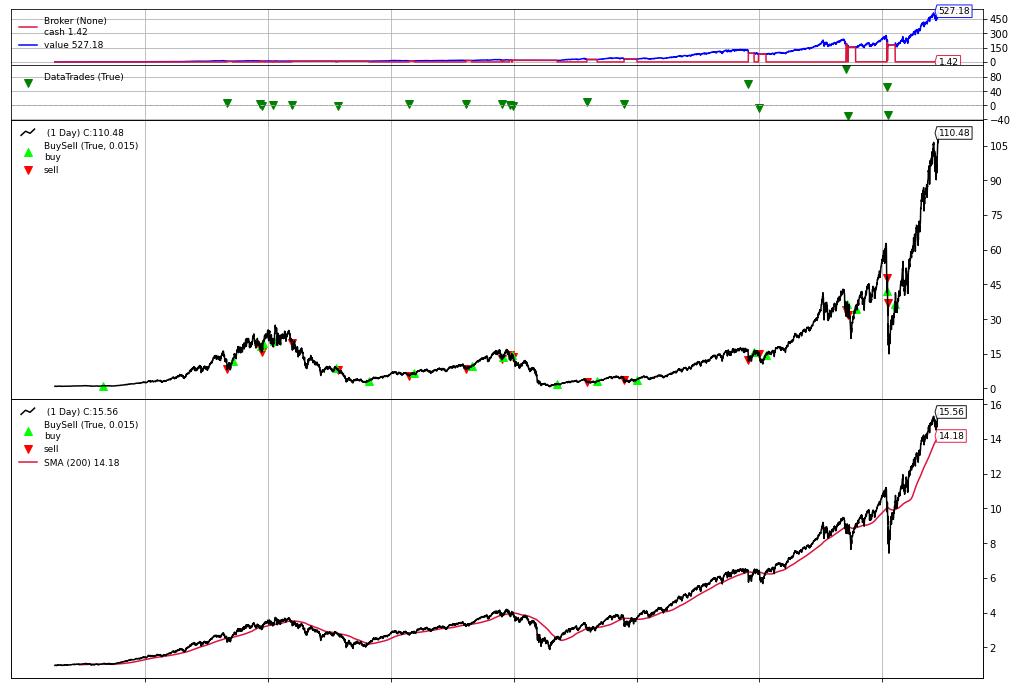

#### Portfolio Returns (Moving Average Cross) : 

Total Returns (for every 1$ invested) : 527.6$
CAGR: 25.07%
Max Drawdown: 50.54%
Sharpe Ratio: 0.69
VWR: 8.51


In [30]:
SingleMA_main = 200

TotalReturns_MA, CAGR_MA, Sharpe_MA, VWR_MA, MaxDrawdown_MA = \
    StrategyPerformance([Stock_trade_bt,Stock_ref_bt ],SingleMACross,inv_initial,start_time,end_time,plot=True, MA_num= SingleMA_main)

display(Markdown('#### Portfolio Returns (Moving Average Cross) : '))
print(f"Total Returns (for every 1$ invested) : {TotalReturns_MA}$\nCAGR: {CAGR_MA}%")
print(f"Max Drawdown: {MaxDrawdown_MA}%\nSharpe Ratio: {Sharpe_MA}\nVWR: {VWR_MA}")

## *Above image shows the performance of moving average cross strategy i.e., we buy/sell SPXL based on whether SPY is above/below it's moving average (200ma).*

## *Unlike previous image, now there are total three rows. Top row is cash/portfolio value as before. Third row is trading ETF (SPXL in this case) that we buy/sell with corresponding points shown as green/red arrows. Fourth row is the reference ETF (SPY in this case) that we use to determine if the market is going up (above 200ma) or down(below 200ma). 2% margin of safety was used to define the crossing of the line.*

## *We can see that, this time, we made 25% on average every year and our max drawdown was only 53% which is similar to SPY. This is amazing performance! Did we find the elusive secret to beat the market ? Should we start a trading firm using this strategy and give Goldman Sachs a run for their money?*

## *Well...not exactly. It is possible that we might be overfitting the data to our strategy. Stock market rhymes but never repeats. Just because a strategy worked for certain period of time, it does not have to work always. But this is an interesting observation (which was also discussed at [SeekingAlpha/LoganKane](https://seekingalpha.com/article/4226165-trading-strategy-beat-s-and-p-500-16-plus-percentage-points-per-year-since-1928)). Similar leveraged ETF strategy using US bonds was discussed by [TeddyKoker](https://teddykoker.com/2019/04/backtesting-portfolios-of-leveraged-etfs-in-python-with-backtrader/).* 

## *There is so much that we can change even in this simple strategy that could give widely different results. For example, does it work for all time periods? What if we use leverage of just 2 instead of 3? May be, including just tech stocks could give even better results? What if we chose 100ma instead of 200ma?*

## *To scratch this curiosity itch, An app is presented below that you can use to chose different ETFs/leverage/time and see the results. Leveraged ETFs were not mentioned by their names to keep it simple. Instead, you can choose an ETF and pick your leverage number.*

# *HAVE FUN EXPLORING !*



In [31]:
# All parameters needed for backtesting 

ETF_list = ['SPY', 'QQQ', 'DIA', 'IWM']
Lev_list = [1,2,3]
SMA_list = np.arange(10,310,10)

Strategy_list = ['BuyAndHold','MovingAverageCross']

Dropdown_ticker_bm_trade = widgets.Dropdown (options= ETF_list, value='SPY', description = 'Trading ETF',
                                         style={'description_width': 'initial'},continuous_update=False)
Dropdown_lev_bm_trade = widgets.Dropdown (options= Lev_list, value=1, description = 'Leverage for trading ETF',
                                         style={'description_width': 'initial'},continuous_update=False)
Dropdown_ticker_bm_ref = widgets.Dropdown (options= ETF_list, value='SPY', description = 'Reference ETF',
                                         style={'description_width': 'initial'},continuous_update=False)
Dropdown_lev_bm_ref =  widgets.Dropdown (options= Lev_list, value=1, description = 'Leverage for reference ETF',
                                         style={'description_width': 'initial'},continuous_update=False)

Dropdown_ticker_test_trade = widgets.Dropdown (options= ETF_list, value='SPY', description = 'Trading ETF',
                                         style={'description_width': 'initial'},continuous_update=False)
Dropdown_lev_test_trade  = widgets.Dropdown (options= Lev_list, value=3, description = 'Leverage for trading ETF',
                                         style={'description_width': 'initial'},continuous_update=False)
Dropdown_ticker_test_ref  = widgets.Dropdown (options= ETF_list, value='SPY', description = 'Reference ETF',
                                         style={'description_width': 'initial'},continuous_update=False)
Dropdown_lev_test_ref = widgets.Dropdown (options= Lev_list, value=1, description = 'Leverage for reference ETF',
                                         style={'description_width': 'initial'},continuous_update=False)

Dropdown_strategy_bm = widgets.Dropdown (options= Strategy_list, value='BuyAndHold', description = 'Strategy',
                                         style={'description_width': 'initial'},continuous_update=False)
Dropdown_strategy_test = widgets.Dropdown (options= Strategy_list, value='BuyAndHold', description = 'Strategy',
                                         style={'description_width': 'initial'},continuous_update=False)

Slider_sma_bm = widgets.IntSlider(min=10,max=300,step=10, value = 200,description = 'Moving Average Number',
                                         style={'description_width': 'initial'}, readout = True,layout = {'width':'600px'},
                                         continuous_update=False)
Slider_sma_test= widgets.IntSlider(min=10,max=300,step=10, value = 200,description = 'Moving Average Number',
                                         style={'description_width': 'initial'}, readout = True,layout = {'width':'600px'},
                                         continuous_update=False)

date_list = pd.date_range(datetime.date(1993,1,1),datetime.date.today()-datetime.timedelta(days=1), freq='D')
date_format = ' %Y%b%d '
date_options = [i.strftime(date_format) for i in date_list]

Slider_date_range = widgets.SelectionRangeSlider(
    options=date_options,  value = (datetime.date(1993,1,1).strftime(date_format) ,datetime.date(2021,1,1).strftime(date_format) ),
    description = 'Investment period', style={'description_width': 'initial'},
    readout = True, layout = {'width':'900px'})  

In [32]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))

display(Markdown('### Initial Investment Assumed : 1$ '))

button = widgets.Button(description="RUN BACKTESTING",layout=widgets.Layout(width='50%', height='90px')); 
button.style.font_weight = 'bold'
output = widgets.Output()

display(Slider_date_range)  

display(Markdown('### Benchmark Portfolio: '))
#display(Dropdown_ticker_bm_trade); display(Dropdown_lev_bm_trade)

RefCheck_bm = widgets.Checkbox(value=False,description='Choose different ETF as reference for MA Cross',indent=False)
@widgets.interact()
def g(ticker_bm_trade=Dropdown_ticker_bm_trade,lev_bm_trade=Dropdown_lev_bm_trade,strategy_bm=Dropdown_strategy_bm):
    if strategy_bm == 'MovingAverageCross':
        #display('None')
        display(Slider_sma_bm); 
        @widgets.interact()
        def g(RefCheck_bm=RefCheck_bm):
            if RefCheck_bm == True :
                display(Dropdown_ticker_bm_ref); display(Dropdown_lev_bm_ref)
            else : 
                Dropdown_ticker_bm_ref.value = ticker_bm_trade
                Dropdown_lev_bm_ref.value = lev_bm_trade
                clear_output()
    else:
        clear_output()        

display(Markdown('### Your Test Portfolio: '))

RefCheck_test = widgets.Checkbox(value=False,description='Choose different ETF as reference for MA Cross',indent=False)
@widgets.interact()
def g(ticker_test_trade=Dropdown_ticker_test_trade,lev_test_trade=Dropdown_lev_test_trade,strategy_test=Dropdown_strategy_test):
    if strategy_test == 'MovingAverageCross':
        #display('None')
        display(Slider_sma_test);
        @widgets.interact()
        def g(RefCheck_test=RefCheck_test):
            if RefCheck_test == True :
                display(Dropdown_ticker_test_ref); display(Dropdown_lev_test_ref)
            else :
                Dropdown_ticker_test_ref.value = ticker_test_trade
                Dropdown_lev_test_ref.value = lev_test_trade
                clear_output()
    else:
        clear_output()

PlotCheck = widgets.Checkbox(value=False,description='Display Backtesting plots',indent=False)
display(PlotCheck)        
        
display(button,output)

def super_bt(daterange ,ticker_bm_trade , lev_bm_trade , ticker_bm_ref , lev_bm_ref,strategy_bm , sma_bm ,
             ticker_test_trade, lev_test_trade, ticker_test_ref , lev_test_ref, strategy_test , sma_test,  
             PlotCheck,
            ) : 
    
    output.clear_output()
    clear_output()
    with output :
        
        
        display(Markdown('## *Backtesting process running....*'))
        date_format = ' %Y%b%d '
        
        start_time_chosen = datetime.datetime.strptime(daterange[0],date_format).date() 
        end_time_chosen = datetime.datetime.strptime(daterange[1],date_format).date()

        #Adjusted times to account for valid 300ma    
        start_time = start_time_chosen - datetime.timedelta(300)
        end_time = end_time_chosen     
     
        Stock_bm_ref_bt = TickerDataBt(ticker_bm_ref, lev_bm_ref, start_time, end_time, stock_leveraged_returns)
        Stock_bm_trade_bt = TickerDataBt(ticker_bm_trade, lev_bm_trade, start_time, end_time, stock_leveraged_returns)

        SingleMA_bm = sma_bm
        
        if PlotCheck.value :
            display(Markdown('#### Backtesting - Benchmark Portfolio : '))
            
        if strategy_bm == 'BuyAndHold' :
            TotalReturns_bm, CAGR_bm, Sharpe_bm, VWR_bm, MaxDrawdown_bm = \
                StrategyPerformance([Stock_bm_trade_bt],BuyAndHold,inv_initial,start_time,end_time,PlotCheck.value)

        elif strategy_bm == 'MovingAverageCross' :
            TotalReturns_bm, CAGR_bm, Sharpe_bm, VWR_bm, MaxDrawdown_bm = \
                StrategyPerformance([Stock_bm_trade_bt,Stock_bm_ref_bt],SingleMACross,inv_initial,start_time,end_time,PlotCheck.value,MA_num=SingleMA_bm)

        Stock_test_ref_bt = TickerDataBt(ticker_test_ref, lev_test_ref, start_time, end_time, stock_leveraged_returns)
        Stock_test_trade_bt = TickerDataBt(ticker_test_trade, lev_test_trade, start_time, end_time, stock_leveraged_returns)

        SingleMA_test = sma_test
 
        if PlotCheck.value :
            display(Markdown('#### Backtesting - Your Test Portfolio : '))

        if strategy_test == 'BuyAndHold' :
            TotalReturns_test, CAGR_test, Sharpe_test, VWR_test, MaxDrawdown_test = \
                StrategyPerformance([Stock_test_trade_bt],BuyAndHold,inv_initial,start_time,end_time,PlotCheck.value)

        elif strategy_test == 'MovingAverageCross' :
            TotalReturns_test, CAGR_test, Sharpe_test, VWR_test, MaxDrawdown_test = \
                StrategyPerformance([Stock_test_trade_bt,Stock_test_ref_bt],SingleMACross,inv_initial,start_time,end_time,PlotCheck.value,MA_num=SingleMA_test)

        Stats_bm = [TotalReturns_bm, CAGR_bm, Sharpe_bm, VWR_bm, -MaxDrawdown_bm]
        Stats_test = [TotalReturns_test, CAGR_test, Sharpe_test, VWR_test,-MaxDrawdown_test]
        
        Stats_bm_norm = [0.75*TotalReturns_bm/abs(max(TotalReturns_test,TotalReturns_bm,key=abs)), \
                         0.75*CAGR_bm/abs(max(CAGR_test,CAGR_bm,key=abs)), \
                         Sharpe_bm/abs(max(Sharpe_test,Sharpe_bm,key=abs)), \
                         VWR_bm/abs(max(VWR_test,VWR_bm,key=abs)), \
                        -MaxDrawdown_bm/abs(max(MaxDrawdown_test,MaxDrawdown_bm,key=abs))]
        Stats_test_norm = [0.75*TotalReturns_test/abs(max(TotalReturns_test,TotalReturns_bm,key=abs)), \
                           0.75*CAGR_test/abs(max(CAGR_test,CAGR_bm,key=abs)), \
                           Sharpe_test/abs(max(Sharpe_test,Sharpe_bm,key=abs)), \
                           VWR_test/abs(max(VWR_test,VWR_bm,key=abs)), \
                          -MaxDrawdown_test/abs(max(MaxDrawdown_test,MaxDrawdown_bm,key=abs))]       
        
        if TotalReturns_bm < 0 :
            Stats_bm_norm[2] = 0 ; Stats_bm_norm[3] = 0 ; 
        if TotalReturns_test < 0 :
            Stats_test_norm[2] = 0 ; Stats_test_norm[3] = 0 ;          
      
        X = np.arange(len(Stats_test))
        
        fig, ax = plt.subplots(1)
        #ax = plt.gca()   
        ax.bar(X, Stats_bm_norm, color = 'green', width = 0.25 )
        ax.bar(X+0.25, Stats_test_norm, color = 'red', width = 0.25 )
        ax.legend(['Benchmark Portfolio','Your Test Portfolio'], fontsize=18, loc = 'lower left')
        Stats_names = ['TotalReturns($)', 'CAGR(%)', 'SharpeRatio', 'VWR', 'MaxDrawdown(%)']
        plt.xticks(X+0.125, Stats_names);
        ax.spines['bottom'].set_position('zero')
        ax.set_xticklabels(Stats_names,fontsize=15, fontweight = 'bold' )
        for i in X:
           if i == 4:
                plt.annotate(Stats_bm[i], (X[i]-0.125, Stats_bm_norm[i] - 0.075), fontsize=15)
                plt.annotate(Stats_test[i], (X[i]+0.15, Stats_test_norm[i] - 0.075), fontsize=15)
                
           elif ( i == 2 or i == 3) : 
                if TotalReturns_bm < 0 : 
                    plt.annotate('NA', (X[i]-0.025, Stats_bm_norm[i] - 0.275), fontsize=15)
                else:
                    plt.annotate(Stats_bm[i], (X[i]-0.125, Stats_bm_norm[i] + 0.02), fontsize=15)                
                if TotalReturns_test < 0 : 
                    plt.annotate('NA', (X[i]+0.2, Stats_test_norm[i] - 0.275), fontsize=15) 
                else:
                    plt.annotate(Stats_test[i], (X[i]+0.15, Stats_test_norm[i] + 0.02), fontsize=15)                    
           else :
                plt.annotate(Stats_bm[i], (X[i]-0.125, Stats_bm_norm[i] + 0.02), fontsize=15)
                plt.annotate(Stats_test[i], (X[i]+0.15, Stats_test_norm[i] + 0.02), fontsize=15)   
        ax.set_title('Portfolio Performance Comparison', fontsize=30, fontweight = 'bold' , y = 0.9)
        plt.ylim(-1.25,1.75); plt.yticks([])        
        
        ax.text(2.0,-0.5,f'Investment Period : {start_time_chosen} to {end_time_chosen}', fontsize =10, fontstyle= 'oblique')
        ax.text(2.0,-0.7,f'Benchmark ETF : {lev_bm_trade}*{ticker_bm_trade} ', fontsize =10, fontstyle= 'oblique')
        ax.text(2.0,-0.8,f'Benchmark Strategy : {strategy_bm} ', fontsize =10, fontstyle= 'oblique')
        ax.text(2.0,-1.0,f'Test ETF : {lev_test_trade}*{ticker_test_trade} ', fontsize =10, fontstyle= 'oblique')
        ax.text(2.0,-1.1,f'Test Strategy : {strategy_test} ', fontsize =10, fontstyle= 'oblique')
        display(Markdown('## *Backtesting process completed !*'))
        plt.close()
        display(fig)

def on_button_clicked(b):
    output.clear_output()
    with output:
        daterange = (Slider_date_range.value[0], Slider_date_range.value[1] )
        ticker_bm_trade = Dropdown_ticker_bm_trade.value; lev_bm_trade = Dropdown_lev_bm_trade.value  
        ticker_bm_ref = Dropdown_ticker_bm_ref.value; lev_bm_ref = Dropdown_lev_bm_ref.value  
        strategy_bm = Dropdown_strategy_bm.value; sma_bm = Slider_sma_bm.value
        ticker_test_trade = Dropdown_ticker_test_trade.value; lev_test_trade = Dropdown_lev_test_trade.value  
        ticker_test_ref = Dropdown_ticker_test_ref.value; lev_test_ref = Dropdown_lev_test_ref.value  
        strategy_test = Dropdown_strategy_test.value; sma_test = Slider_sma_test.value
        plt.close()
        #fig, ax = plt.subplots()    
        super_bt(daterange ,ticker_bm_trade , lev_bm_trade , ticker_bm_ref , lev_bm_ref,strategy_bm , sma_bm ,
                 ticker_test_trade, lev_test_trade, ticker_test_ref , lev_test_ref, strategy_test , sma_test, 
                 PlotCheck = PlotCheck
                )
        plt.close()
        display()

button.on_click(on_button_clicked)

#%%javascript
#IPython.OutputArea.auto_scroll_threshold = 9999

### Initial Investment Assumed : 1$ 

SelectionRangeSlider(description='Investment period', index=(0, 10227), layout=Layout(width='900px'), options=…

### Benchmark Portfolio: 

interactive(children=(Dropdown(description='Trading ETF', options=('SPY', 'QQQ', 'DIA', 'IWM'), style=Descript…

### Your Test Portfolio: 

interactive(children=(Dropdown(description='Trading ETF', options=('SPY', 'QQQ', 'DIA', 'IWM'), style=Descript…

Checkbox(value=False, description='Display Backtesting plots', indent=False)

Button(description='RUN BACKTESTING', layout=Layout(height='90px', width='50%'), style=ButtonStyle(font_weight…

Output()

In [33]:


display(CodeToggleButton)

ToggleButton(value=False, description='Show code')